In [2]:
import os 
import sys
import re 
import glob
import json




import pandas as pd 
import numpy as np 
import torch
import torchvision
import cv2 
import matplotlib.pyplot as plt 


 

current_dir = os.getcwd()

 
dataset_dir = os.path.join(current_dir, 'dataset')


sys.path.insert(0, dataset_dir)


### Brainwash Dataset 

In [3]:
def replace_multiple(text, replacements):
    # Create a regex pattern that matches any of the keys
    pattern = re.compile("|".join(re.escape(key) for key in replacements.keys()))
    
    # Function to return the replacement value
    return pattern.sub(lambda match: replacements[match.group(0)], text)


def turn_toInt(x):
    x = x.lstrip().rstrip()    
    x =int(float(x))
    return x


replacements = {
    '(' :"",
    ')' : "",
    ';': "",
}

In [ ]:


file_paths = glob.glob(os.path.join(dataset_dir, 'brainwash', '*.idl'), recursive=True)







for file_path in file_paths:
    print(file_path)
    with open(file_path,'r') as file:
        content = file.readlines()

    coco_format = {
    "images": [],
    "annotations": [],
    "categories": [
        {
            "id": 1,
            "name": "person",  
            "supercategory": "none"
        }
    ]
}




    bb_per_line = []
    for i,line in enumerate(content):
        line_arr  = line.rstrip().split(':')
        if(len(line_arr)==2):
            img_name = line_arr[0]
            boxes =  replace_multiple(line_arr[1],replacements).split(',')
            
            boxes = np.asarray(list(map(turn_toInt,boxes)))
            boxes = boxes.reshape(-1, 4)
            boxes= list(boxes)
            bb_per_line.append(boxes)
            image_info = {
                "id": i + 1,  # Unique image ID
                "file_name": img_name,
                "width": 640,  # Set your image width
                "height": 480  # Set your image height
            }
            coco_format["images"].append(image_info)
            for bbox_id, bbox in enumerate(boxes, start=1):
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min
                coco_format["annotations"].append({
                    "id": i + 1,
                    "image_id": image_info["id"],
                    "category_id": 1,  # Corresponding category ID
                    "bbox": [int(x_min), int(y_min), int(width), int(height)],  # COCO format: [x, y, width, height]
                    "area": float(width * height),  # Area of the bounding box
                    "iscrowd": 0,  # 0 if not a crowd
                    "segmentation": []
                })
            
    file_name_with_extension = os.path.basename(file_path)
    output_file, _ = os.path.splitext(file_name_with_extension)
    output_path = os.path.join('dataset\\brainwash',f'{output_file}.json')
    with open(output_path, 'w') as json_file:
        
        json.dump(coco_format, json_file, indent=4)

        print(f"COCO format data has been saved to {output_path}.")
        
    

## CamVid

dataset\CamVid\train_labels\0001TP_009210_L.png


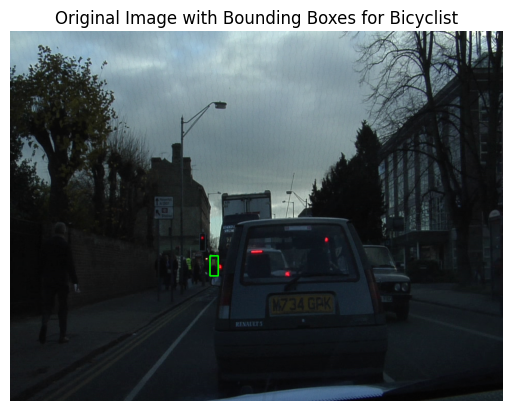

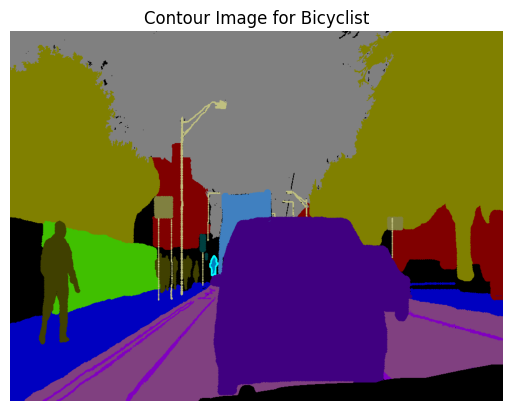

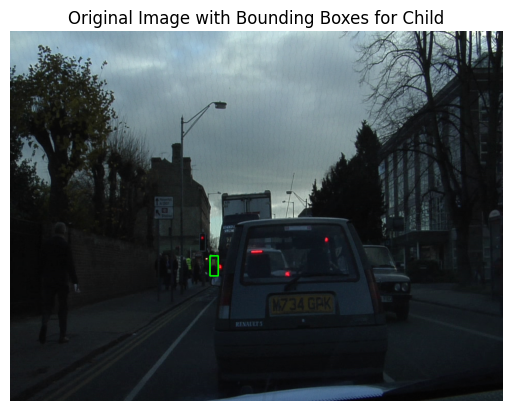

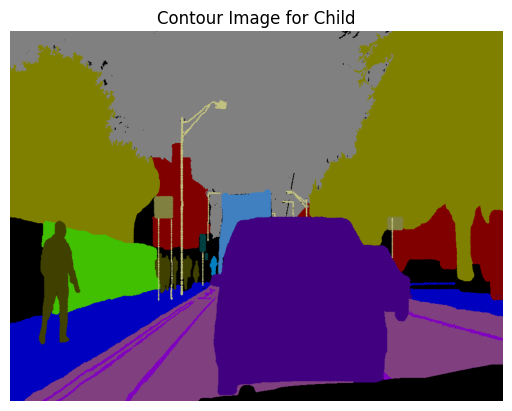

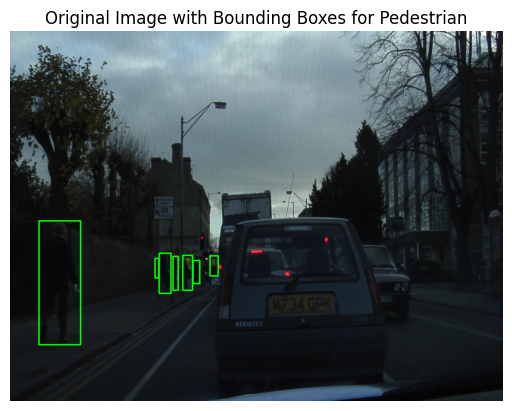

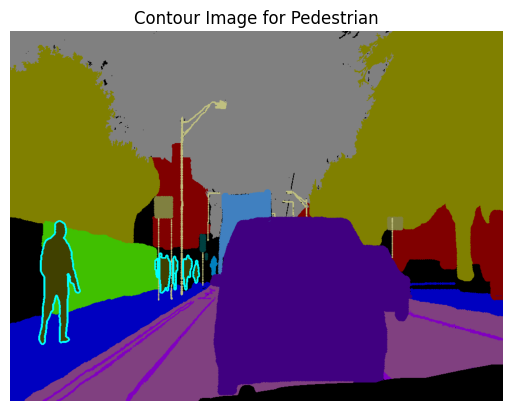

dataset\CamVid\train_labels\0001TP_009240_L.png


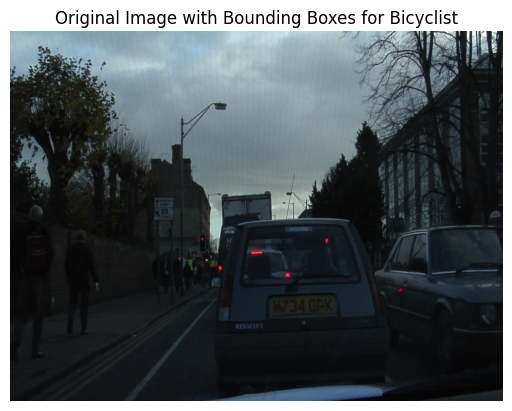

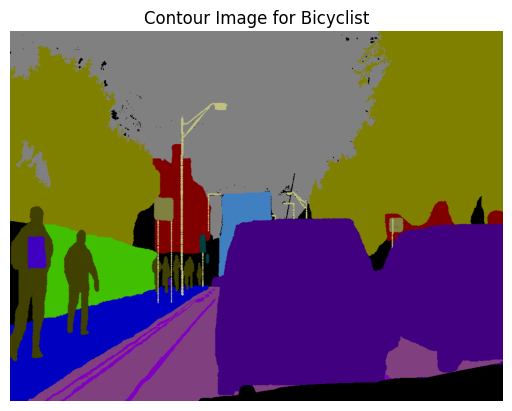

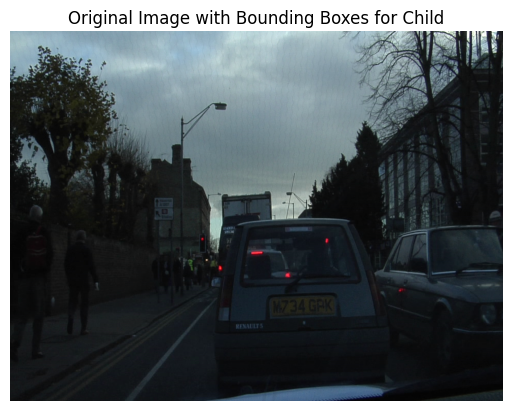

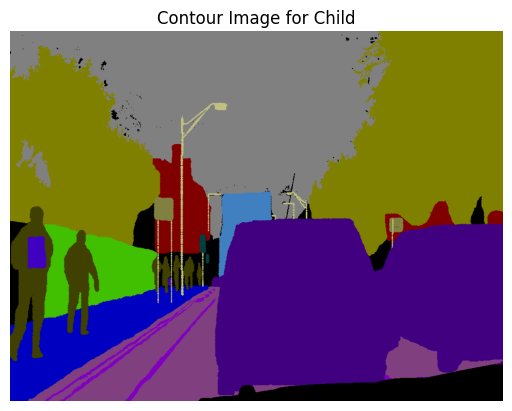

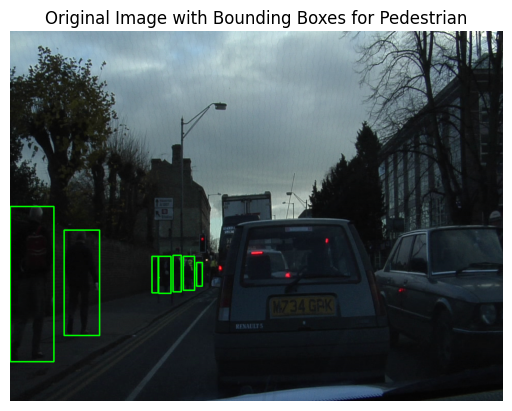

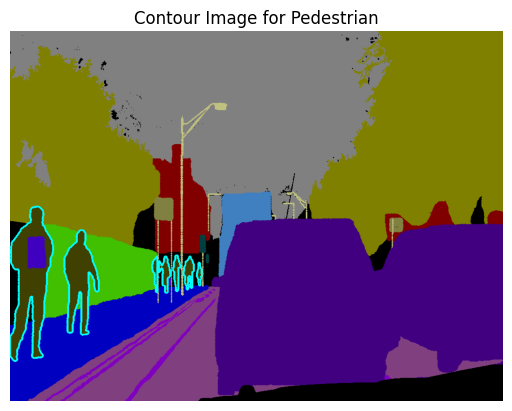

dataset\CamVid\train_labels\0001TP_009390_L.png


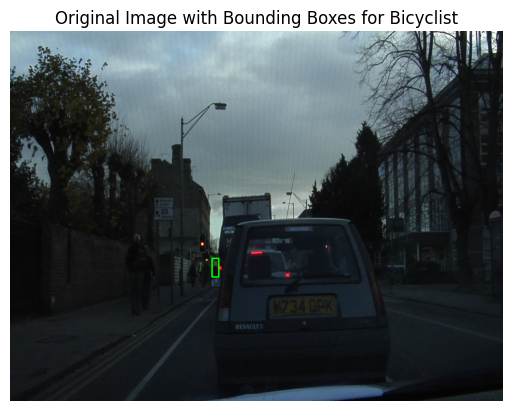

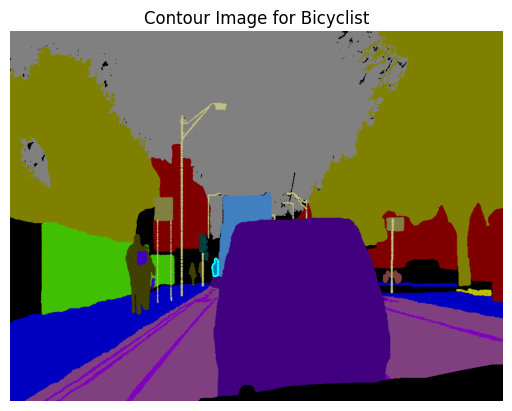

KeyboardInterrupt: 

In [33]:
camvid_dataset_path = f'dataset\CamVid'
label_mask =[]
label_df = pd.read_csv("dataset\CamVid\class_dict.csv")

images_test = glob.glob(os.path.join(camvid_dataset_path,'test','*.png'),recursive=True)
images_train =glob.glob(os.path.join(camvid_dataset_path,'train','*.png'),recursive=True)
images_val = glob.glob(os.path.join(camvid_dataset_path,'val','*.png'),recursive=True)

labels_test =glob.glob(os.path.join(camvid_dataset_path,'test_labels','*.png'),recursive=True)
labels_train =glob.glob(os.path.join(camvid_dataset_path,'train_labels','*.png'),recursive=True)
labels_val = glob.glob(os.path.join(camvid_dataset_path,'val_labels','*.png'),recursive=True)



zipped_test = list(zip(images_test, labels_test))
zipped_train = list(zip(images_train, labels_train))
zipped_val = list(zip(images_val, labels_val))


class_colours  = {}
for index , row in label_df.iterrows():
    class_colours[row['name']] = (row['b'],row['g'],row['r']) #cv rads images as bgr

contours_dict = {}

for image_path, label_path in zipped_train:
    print(label_path)
    label_image = cv2.imread(label_path)
    image = cv2.imread(image_path)
    label_image_gray =cv2.cvtColor(label_image, cv2.COLOR_BGR2GRAY)
    # Step 1: Iterate through each class color
    for class_name, color in class_colours.items():
        # Create a binary mask for the current class using RGB encoding
        mask = cv2.inRange(label_image, color, color)
        
       
        # Visualize the mask
      
        # Step 2: Find contours in the binary mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Store the contours in the dictionary
        contours_dict[class_name] = contours

        # Step 3: Draw bounding boxes for each contour
        for contour in contours:
            # Get the bounding box for the contour
            x, y, w, h = cv2.boundingRect(contour)
            
            # Draw the bounding box on the original image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw in green

        # Optional: Draw contours on the original label image
        contour_image = label_image.copy()
        cv2.drawContours(contour_image, contours, -1, (255, 255, 0), 2)  # Draw contours in cyan

        # Display the original image with bounding boxes
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
        plt.title(f'Original Image with Bounding Boxes for {class_name}')
        plt.axis('off')
        plt.show()

        # Optional: Display the contour image
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
        plt.title(f'Contour Image for {class_name}')
        plt.axis('off')
        plt.show()




